## Is There Depression in This Reddit Post?

Dataset Source: https://www.kaggle.com/datasets/infamouscoder/depression-reddit-cleaned

##### Import necessary Libraries

In [0]:
import pandas as pd

import pyspark
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
import pyspark.sql.functions as F
from pyspark.ml import Pipeline

import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

##### Versions of Libraries, Modules, Frameworks Used in This Project

In [0]:
print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

Spark NLP version 4.2.4
Apache Spark version: 3.2.1


#### Create Functions That Are Used Throughout Project

##### Function to Ingest Dataset

In [0]:
def ingest_dataset(file_location: str, \
                   schema: StructType \
                  ) -> pyspark.sql.dataframe.DataFrame:
    '''
    This function ingests a csv file and fits it with a schema
    '''
    file_type = "csv"
    infer_schema = "false"
    first_row_is_header = "true"
    delimiter = ","
    
    dataset = spark.read.format(file_type) \
        .option("inferSchema", infer_schema) \
        .option("header", first_row_is_header) \
        .option("sep", delimiter) \
        .schema(schema) \
        .load(file_location)
    
    return dataset

##### Metrics Evaluation Function

In [0]:
def metrics_eval(prediction: pd.Series, \
                 label: pd.Series, \
                 model_name: str, \
                 label_values: []\
                ) -> None:
    '''
    This function calculates and displays the following metrics:
    - Classification Report (including accuracy, recall, precision, 
       & F1-score, among others)
    - Confusion Matrix
    '''
    
    from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
    
    print("-------------------------------------------------------------------------------------")
    print("| " + ("The %s Model" % model_name).center(81) + " |")
    print("-------------------------------------------------------------------------------------")
    print("| " + f"Classification Report for the {model_name} Model".center(81) + " |")
    print("-------------------------------------------------------------------------------------\n")

    if label_values != []:
        report = classification_report(label, prediction, zero_division=1, target_names=label_values)
    else:
        report = classification_report(label, prediction, zero_division=1)
    print(report)

    print("-------------------------------------------------------------------------------------")

    print("| " + f"Confusion Matrix for the {model_name} Model".center(81) + " |")
    cm = confusion_matrix(label, prediction)
    
    if label_values != []:
        dist = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_values)
    else:
        dist = ConfusionMatrixDisplay(confusion_matrix=cm)
    dist.plot()

    print("-------------------------------------------------------------------------------------")

#### Prepare Data For Model

##### Ingest Dataset

In [0]:
data_file = "/FileStore/tables/depression_dataset_reddit_cleaned.csv"

orig_schema = StructType([
    StructField("text", StringType(), True),
    StructField("labels", StringType(), True),
])

df = ingest_dataset(data_file, orig_schema)

df = df.na.drop(how='any')

df = df.dropDuplicates()

display(df)

text,labels
i think i m happy i ve just went through a couple of month of sad dark feeling and thought best way i can explain it is a painful emptiness inside of me mentally for most of my life i ve always remember going through these phase it never a on or off switch it just kinda slowly engulf me one day i feel a little bit sad and it start this snowball effect after a couple of month of the constant painful emotionless feeling i keep getting the same thought of just ending myself but today i think i m happy it weird to explain but life seems a bit more vibrant music is touching me emotionally to the point i want to sing i hope today is the start of my happy phase and i really hope it last just a long i m so desperate to feel something again,1
i don t know if it just my ocd acting up or if it some real trauma but in high school i had a friend that really lowered my self esteem told me that i have no one to talk to always alone more i speak the dumber i sound kind of treat me like shit at every possibility sometimes trying to embarrass me in front of other it wasn t just towards me but i think because i wa so nice to him he took advantage of that anyways it been year and it still bug me i did have therapy and to be honest it wa quite useless there is simply not much a stranger can do to help my situation i wa always a very sensitive avoidant person and running into a person like that really destroyed me not just that but hate that i didn t stand up for myself my therapist recommends meditation and slowly getting yourself out there but almost none of it help i don t understand why someone would come into someone s personal space and violate you for no particular reason he didn t do that because he found it funny just did it for the sake of it i hate disagreeable people like him and fear running into people like that i also stated skipping class from then on i spent the last year of college in my room skipping nearly all my class,1
i m sincerely done with this living my saving ha finally dried up i will soon lose my home my car and am unable to find work regardless i m just done i ve grown so tired of being tired,1
about three week ago i quit my job of year after believing spending all my time at work wa making me severely depressed day after i quit were the happiest i ve been in a long time but it quickly went away and i got trapped into another very depressed cycle i haven t put any work towards anything in week just moping around all day until i have to go to sleep my biggest problem is that i feel like i m watching my dream die i would love to entertain people like how most people do on youtube etc but i have no talent no skill and a horrible lisp i ve started many project but have stopped all of them really early a i have no motivation to keep doing them anyway the only option i have left in life is to go work another job be unhappy and live the same miserable life or i can kill myself it sound bad but i don t have any problem with suicide my whole life is built on regret and failure with nothing that i can truly be proud of honestly i don t want to go through with this but it feel like the better choice,1
im gon na copy and paste the title just to continue the story from that point on so here go nothing this ha been the worst month of my life but ill start with a light hearted day earlier this month a meth head tried to take my phone the bitch at the ssi building tried to 0 me then i got bit by a dog all in the same day what i dont understand is that im more upset about this pale blonde brazilian girl i met and lost in a span of day might be bipolar a well what i dont understand is how can i handle a fucked up day like that like it nothing and go through thing that could end in death seem to recover in minute but small thing like family argument or this situation with this girl seem to make me feel upset for so long i dont understand that at all i hope thing get better but ever since i droped acid about week ago this ha b

##### Split Dataset into Training & Testing Datasets

In [0]:
train_ds, test_ds = df.randomSplit(weights=[0.80, 0.20], seed=42)

train_ds = train_ds.persist()
test_ds = test_ds.persist()

##### Build Pipeline Stages

In [0]:
doc = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("doc")

use = UniversalSentenceEncoder\
    .pretrained() \
    .setInputCols("doc") \
    .setOutputCol("use")

clf = ClassifierDLApproach() \
    .setInputCols("use") \
    .setOutputCol("category") \
    .setLabelColumn("labels") \
    .setBatchSize(128) \
    .setMaxEpochs(12)

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


##### Build Pipeline

In [0]:
dep_clf_pipe = Pipeline().setStages([
    doc,
    use,
    clf
])

##### Fit Pipeline to Training Dataset

In [0]:
dep_clf_model = dep_clf_pipe.fit(train_ds)

##### Generate Predictions Using Testing Dataset

In [0]:
predictions = dep_clf_model.transform(test_ds)

##### Prepare Predictions for Metris Evaluation Function

In [0]:
preds = (predictions.select(F.col("labels").alias("ground_truth"), F.col("category.result").alias("predictions"))).toPandas()

preds['predictions'] = preds['predictions'].apply(lambda x : x[0])

##### Evaluate & Display Metrics

-------------------------------------------------------------
The Fake News Classifier Model
-------------------------------------------------------------
Classification Report for the Fake News Classifier Model:
               precision    recall  f1-score   support

No Depression       0.97      0.97      0.97       782
   Depression       0.97      0.97      0.97       777

     accuracy                           0.97      1559
    macro avg       0.97      0.97      0.97      1559
 weighted avg       0.97      0.97      0.97      1559

-------------------------------------------------------------
Confusion Matrix for the Fake News Classifier Model:
-------------------------------------------------------------


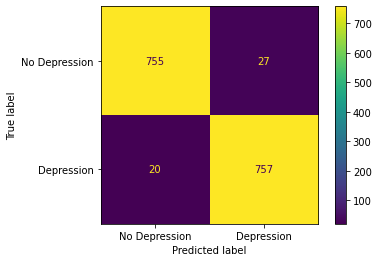

In [0]:
label_values = ["No Depression", "Depression"]

metrics_eval(preds["ground_truth"], preds["predictions"], "Fake News Classifier", label_values)

##### End Spark Session

In [0]:
train_ds = train_ds.unpersist()
test_ds = test_ds.unpersist()

spark.stop()

### Notes & Other Takeaways From This Project
****
- The Result is not too surprising. I am elated with the result.
****
- Not only is the accuracy 97%, but the F1 Score, Recall, and Precision are 97% as well, which shows balance. It shows that the model is actually working to classify text inputs. It is not just quessing that all of the inputs are of the majority class!
****